In [ ]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


**Считываем, формируем признаки и целевую**

In [86]:
df = pd.read_csv('data_eda.csv')

# Должны исключить из признаков саму целевую переменную и один из зависимых признаков IC50 или CC50
X = df.drop(['CC50, mM', 'SI'], axis=1)
y = df['SI']

**Оценим зависимость признаков и целевой переменной с помощью Mutual Info**

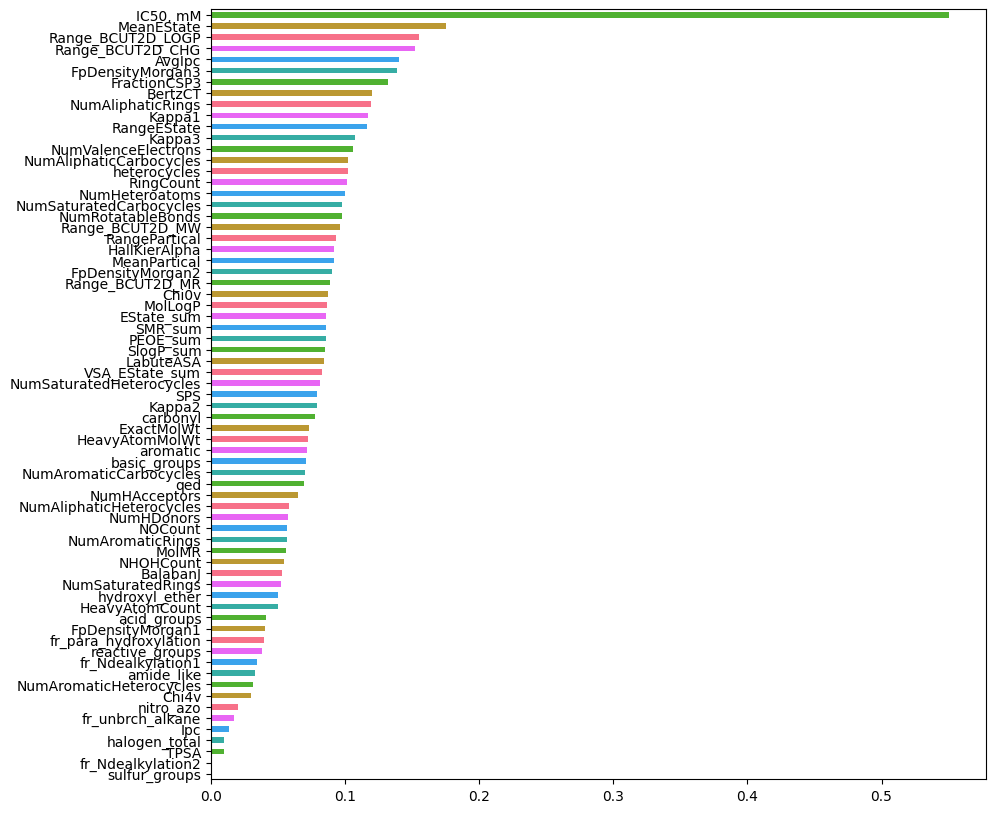

In [87]:
# Изучим зависимость признаков
importances = mutual_info_regression(X, y)

feature_importances = pd.Series(importances, X.columns[0:len(X.columns)])
feature_importances = feature_importances.sort_values()

colors = sns.color_palette("husl")
plt.figure(figsize=(10,10))
feature_importances.plot(kind='barh', color=colors)
plt.show()

**Уберем менее значимые признаки**

In [88]:
X.drop(columns=feature_importances.index[0:9], inplace=True)

**Делим данные на тестовые и тренировочные**

In [89]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% данных в тест, 80% в трейн
    random_state=42,    # для воспроизводимости         
)

**Стандартизируем данные**

In [90]:
scaler = StandardScaler()

X_train_scaler = scaler.fit_transform(X_train)

X_test_scaler = scaler.transform(X_test)

**Уменьшим количество признаков сохранив 97.5% дисперсии**

In [91]:
pca = PCA(n_components=0.975)  # 97.5%

X_train_pca = pca.fit_transform(X_train_scaler)

X_test_pca = pca.transform(X_test_scaler)

## **Модель линейной регрессии**

In [92]:
# Создадим модель
lig_reg = LinearRegression()
lig_reg.fit(X_train_pca, y_train)

# Предсказываем значения
y_pred = lig_reg.predict(X_test_pca)

# Считаем метрики
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.3f}\nMean Squared Error: {mse:.3f}\nRoot Mean Squared Error: {rmse:.3f}\nКоэффициент детерминации: {r2:.3f}")

Mean Absolute Error: 0.938
Mean Squared Error: 1.505
Root Mean Squared Error: 1.227
Коэффициент детерминации: 0.490


> **Mean Absolute Error (MAE) = 0.938**

Средняя абсолютная ошибка показывает, что в среднем предсказания модели отклоняются от фактических значений на 0.938 единицы.

> **Mean Squared Error (MSE) = 1.505**

Среднеквадратичная ошибка усиливает влияние больших ошибок за счет возведения в квадрат. Её значение 1.505 указывает на наличие отдельных значительных отклонений

> **Root Mean Squared Error (RMSE) = 1.227**

Корень из MSE, интерпретируемый в исходных единицах измерения, показывает, что стандартное отклонение ошибок составляет 1.227. Это выше MAE, что подтверждает неустойчивость модели на части данных

> **Коэффициент детерминации (R²) = 0.490**

Модель объясняет почти 49% дисперсии целевой переменной, что указывает на умеренное качество

> **Необходимо продолжить поиск наилучшей модели!**


## **Модель KNeighborsRegressor**

In [ ]:
# Определяем модель
model = KNeighborsRegressor()

# Задаем сетку гиперпараметров для перебора
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],  # количество соседей
    'weights': ['uniform', 'distance'],  # способ взвешивания соседей
    'p': [1, 2],  # метрика 
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # алгоритм поиска соседей
}

# Создаем GridSearchCV объект
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Запускаем поиск
grid_search.fit(X_train_pca, y_train)

# Выводим лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'algorithm': 'kd_tree', 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}


In [94]:
# Переменная для лучшей модели
best_knn = grid_search.best_estimator_

# Предсказываем значения
y_pred = best_knn.predict(X_test_pca)

# Считаем метрики
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.3f}\nMean Squared Error: {mse:.3f}\nRoot Mean Squared Error: {rmse:.3f}\nКоэффициент детерминации: {r2:.3f}")

Mean Absolute Error: 1.060
Mean Squared Error: 1.872
Root Mean Squared Error: 1.368
Коэффициент детерминации: 0.366


**Текущие результаты недостаточны для надежного прогнозирования**

**Все метрики хуже модели линейной регрессии**

> **Продолжаем поиск наилучшей модели!**

## **Модель GradientBoostingRegressor**


In [95]:
# Создаем модель
gb = GradientBoostingRegressor(random_state=42)

# Определяем сетку параметров для поиска
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# Создаем GridSearchCV объект
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='r2'
)

# Запускаем поиск по сетке
grid_search.fit(X_train_pca, y_train)

# Выводим лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}


In [96]:
# Переменная для лучшей модели
best_gb = grid_search.best_estimator_

# Предсказываем значения
y_pred = best_gb.predict(X_test_pca)

# Считаем метрики
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.3f}\nMean Squared Error: {mse:.3f}\nRoot Mean Squared Error: {rmse:.3f}\nКоэффициент детерминации: {r2:.3f}")

Mean Absolute Error: 0.920
Mean Squared Error: 1.396
Root Mean Squared Error: 1.182
Коэффициент детерминации: 0.527



Модель явно превосходит другие модели, так как демонстрирует меньшие ошибки прогноза и лучше описывает зависимость между признаками и целевой переменной


Однако значение R² = 0.527 всё ещё указывает Все равно показывает среднее качество

## **Модель RandomForestRegressor**

In [97]:
# Создание модели
rf = RandomForestRegressor(random_state=42)

# Параметры для Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],  # Количество деревьев
    'max_depth': [None, 10, 20, 30],  # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10],  # Минимальное число образцов для разделения узла
    'min_samples_leaf': [1, 2, 4],    # Минимальное число образцов в листе
    'max_features': ['sqrt']   # Количество признаков для поиска лучшего разбиения
}

# Настройка Grid Search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5, 
    n_jobs=-1,  
    scoring='r2',
    error_score='raise')

# Запуск Grid Search
grid_search.fit(X_train_pca, y_train)

# Лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [98]:
# Переменная для лучшей модели
best_rf = grid_search.best_estimator_

# Предсказываем значения
y_pred = best_rf.predict(X_test_pca)

# Считаем метрики
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.3f}\nMean Squared Error: {mse:.3f}\nRoot Mean Squared Error: {rmse:.3f}\nКоэффициент детерминации: {r2:.3f}")

Mean Absolute Error: 0.930
Mean Squared Error: 1.452
Root Mean Squared Error: 1.205
Коэффициент детерминации: 0.508


**Модель RandomForestRegressor не превзошла предыдущую модель по метрикам**

После тщательного сравнения производительности моделей RandomForestRegressor и GradientBoostingRegressor было установлено, что градиентный бустинг демонстрирует более высокую предсказательную способность по ключевым метрикам

GradientBoostingRegressor показал себя как более сбалансированное и эффективное решение